# custom dataset 

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceFunctionEval,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)

from opendataval.experiment import ExperimentMediator

from opendataval.model.api import ClassifierSkLearnWrapper
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## [Step 1] Set up an environment

### [Step 1-1] Register a dataset
`ExperimentMediator.model_factory_setup()` is convenient, but it only works for datasets registered in `opendataval`. To apply `opendataval` to your custome datasets, a user first needs to register a dataset and define a `DataFetcher` from the registered dataset. The following codes demonstrate how to register a dataset from arrays of (random) features and (random) labels.

In [2]:
# Set up hyperparameters
dataset_name = "random_dataset"
train_count, valid_count, test_count = 50, 10, 10
noise_rate = 0.1
model_name = "sklogreg"
metric_name = "accuracy"

# Generate a random dataset
X, y= np.random.normal(size=(100, 10)), np.random.choice([0,1], size=100)

In [3]:
# Register a dataset from arrays X and y
pd_dataset = Register(dataset_name=dataset_name, one_hot=True).from_data(X, y)

# After regitering a dataset, we can define `DataFetcher` by its name.
fetcher = (
    DataFetcher(dataset_name, '../data_files/', False)
    .split_dataset_by_count(train_count,
                            valid_count,
                            test_count)  
    .noisify(mix_labels, noise_rate=noise_rate)
)

### [Step 1-2] Set up a prediction model
Next is to set up a prediction model. With `ClassifierSkLearnWrapper` and `RegressionSkLearnWrapper`, any `sklearn` models can be utilized as a prediction model. The following code uses a random forest classifier `RandomForestClassifier`. 

In [4]:
# pred_model = ClassifierSkLearnWrapper(LogisticRegression, fetcher.label_dim[0]) # example of Logistic regression
pred_model = ClassifierSkLearnWrapper(RandomForestClassifier, fetcher.label_dim[0])

### [Step 1-3] Combining all 
- Combining [Step 1-1] and [Step 1-2] with `ExperimentMediator`

In [5]:
exper_med = ExperimentMediator(fetcher, pred_model)

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [6]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
#     InfluenceFunctionEval(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
#     DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley
#     BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley
#     DataBanzhaf(num_models=1000), # Data-Banzhaf
#     AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(),
#     RobustVolumeShapley(mc_epochs=300)
]

In [7]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.014107


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.72it/s]


Elapsed time LeaveOneOut(): 0:00:04.769932


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:50<00:00, 11.71it/s]


Elapsed time DVRL(rl_epochs=2000): 0:02:51.145168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 15803.22it/s]


Elapsed time KNNShapley(k_neighbors=10): 0:00:00.008487


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.80it/s]


Elapsed time DataOob(num_models=1000): 0:01:24.729439


Elapsed time LavaEvaluator(): 0:00:00.030856
CPU times: user 4min 15s, sys: 981 ms, total: 4min 16s
Wall time: 4min 20s


## [Step 3] Evaluate data values

In [8]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/random_dataset_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [9]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
DVRL(rl_epochs=2000),0.142857
DataOob(num_models=1000),0.111111
KNNShapley(k_neighbors=10),0.235294
LavaEvaluator(),0.205128
LeaveOneOut(),0.071429
RandomEvaluator(),0.133333


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

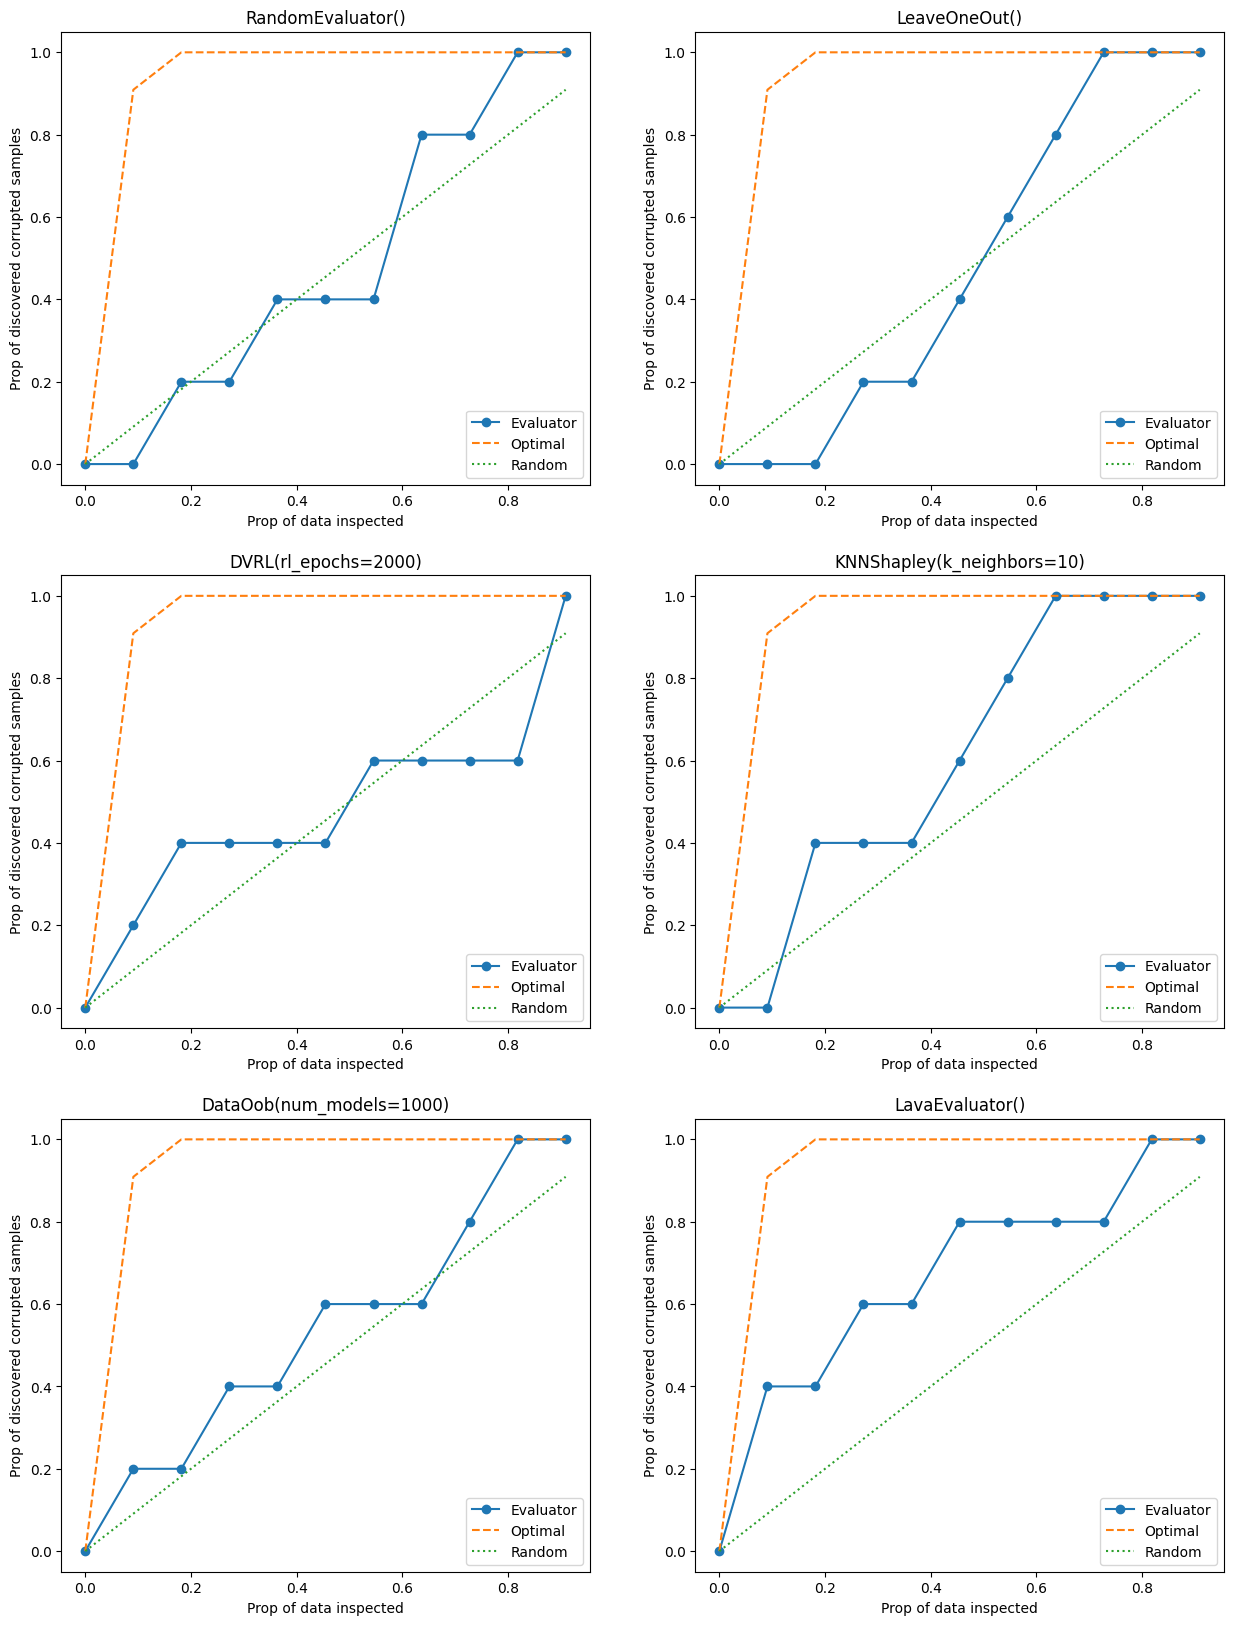

In [10]:
fig = plt.figure(figsize=(15, 20))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

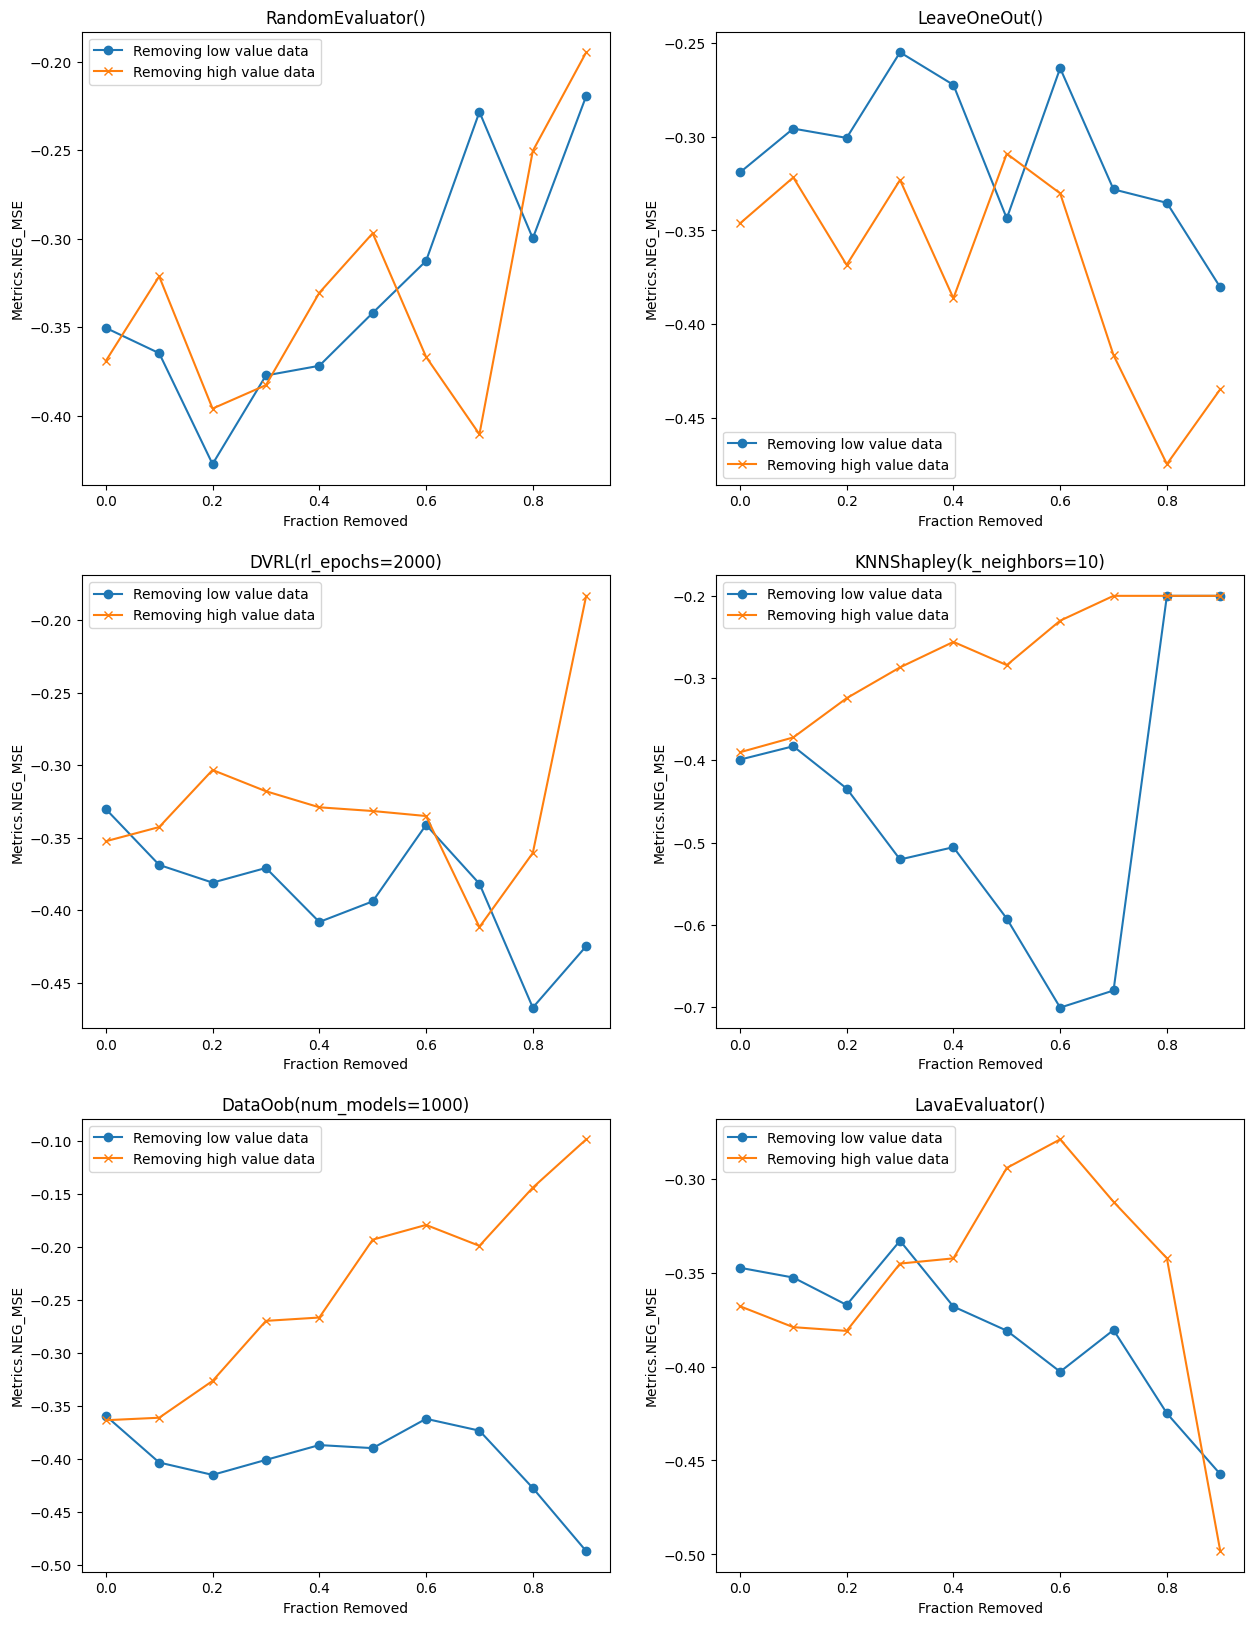

In [11]:
fig = plt.figure(figsize=(15, 20))
df_resp, fig = exper_med.plot(remove_high_low, fig, include_train=True, col=2, save_output=True)

In [12]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.NEG_MSE,remove_most_influential_first_Metrics.NEG_MSE,axis
RandomEvaluator(),-0.35034,-0.36903,0.0
RandomEvaluator(),-0.36463,-0.32126,0.1
RandomEvaluator(),-0.42726,-0.39591,0.2
RandomEvaluator(),-0.37721,-0.38267,0.3
RandomEvaluator(),-0.37174,-0.33051,0.4
RandomEvaluator(),-0.34188,-0.29688,0.5
RandomEvaluator(),-0.31253,-0.36669,0.6
RandomEvaluator(),-0.22836,-0.41042,0.7
RandomEvaluator(),-0.29976,-0.25039,0.8
RandomEvaluator(),-0.21941,-0.19469,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [13]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),1,0.691378
RandomEvaluator(),26,0.650357
RandomEvaluator(),7,0.049292
RandomEvaluator(),64,0.53356
RandomEvaluator(),44,0.994644
...,...,...
LavaEvaluator(),8,-0.293992
LavaEvaluator(),70,3.877471
LavaEvaluator(),99,-0.707993
LavaEvaluator(),47,-1.257114
